In [2]:
import os
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from skorch import NeuralNetClassifier
from torch.autograd import Variable
import gc

In [1]:
# load the data
data_directory = 'D:\\Work\\City University of London\\Neural Computing\\Individual Project\\data'

# loop through all files in directory
data = pd.read_csv("data/part-009.csv")
print("Loading part-009.csv")

for filename in os.listdir(data_directory):
    if filename.endswith('.csv') and filename.startswith('part-'):
        if filename in ["part-009.csv", "preprocessed_data.csv"]:
            continue

        print(f"Loading {filename}")
        new_data = pd.read_csv(data_directory + "\\" + filename, engine="pyarrow")
        data = pd.concat([data, new_data], axis=0)

print(f"Number of anomalies: {data['isAnomaly'].value_counts()}")


KeyboardInterrupt



# Preprocessing

## Helper functions

In [3]:
TARGET_COL = "isAnomaly"
class_names = ["Anomaly", "No Anomaly"]
RND_SEED = 42
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def scale_dataset(df: pd.DataFrame, df_scale_exclude_names, scaler):
    """
    This function takes a pandas dataframe 'df' and a list of column name that don't need to be scaled as input and returns a scaled dataframe.

    Parameters:
    -----------
    df: A pandas dataframe with columns that need to be scaled

    df_scale_exclude_names
        A list of strings containing column names that shall be excluded from scaling.

    Returns:
    --------
    df
        The dataframe with applied scaling
    """
    df_scale_exclude = df[df_scale_exclude_names]
    df_scale_include = df.drop(df_scale_exclude_names, axis=1)
    df_scale_include_names = df_scale_include.columns
    df_scale_include = scaler.fit_transform(df_scale_include)
    df_scale_include = pd.DataFrame(data=df_scale_include, columns=df_scale_include_names)
    df_scale_include = df_scale_include.reset_index(drop=True)
    df_scale_exclude = df_scale_exclude.reset_index(drop=True)
    scaled_df = pd.concat([df_scale_include, df_scale_exclude], axis=1)
    return scaled_df


def get_constant_value_features(df: pd.DataFrame):
    """
    This function takes a pandas dataframe as input, and returns a list of column names that contain only one unique value.
    Code originally from https://www.kaggle.com/code/yashikachugh/anomaly-detection-all-in-one.

    Parameters:
    -----------
    df: A pandas dataframe with columns that need to be checked for constant values

    Returns:
    --------
    list
        A list of column names that have only one unique value
    """
    return [column for column in df.columns if df[column].nunique() == 1]


def get_highly_correlated_features(df: pd.DataFrame, threshold: float = 0.95):
    """
    This function takes a pandas dataframe 'df' as input and returns a list of column names that are highly correlated.
    Code originally from https://www.kaggle.com/code/yashikachugh/anomaly-detection-all-in-one.

    Parameters:
    -----------
    df: A pandas dataframe with columns that need to be checked for highly correlated features

    threshold: float, default=0.95
        A float value between 0 and 1 specifying which columns are considered highly correlated.

    Returns:
    --------
    list
        A list of column names that are highly correlated.
    """
    corr_matrix = df.corr()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    return [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]


def one_hot_encoding(df: pd.DataFrame, column_name: str):
    """
    This function takes a pandas dataframe 'df' and a column name as input and returns a dataframe with one hot encoding of said column.

    Parameters:
    -----------
    df: A pandas dataframe with columns that need to be one-hot encoded

    column_name: str
        A string containing the column that needs to be encoded.

    Returns:
    --------
    df
        The dataframe with one hot encoded features
    """
    ohe = pd.get_dummies(df[column_name], prefix=column_name)
    df = pd.concat([df, ohe], axis=1)
    df = df.drop(column_name, axis=1)
    return df


def x_y_split(df: pd.DataFrame, target_column: str):
    """
    This function takes a pandas dataframe 'df' and the column name of the target variable and returns the split dataset as X and y.

    Parameters:
    -----------
    df: A pandas dataframe with predictors

    target_column: str
        The name of the target column.

    Returns:
    --------
    X: pandas.DataFrame
        All predictors
    Y: pandas.Series
        The target variable
    """
    y = df[target_column]
    X = df.drop(target_column, axis=1)
    return X, y


def plot_target_col(df: pd.DataFrame, target_col: str, max_y: int, y_tick_interval: int, target_class_names: [str],
                    pdf_filename: str):
    """
    Creates a bar chart of a binary target variable in a Pandas DataFrame.

    Parameters:
    -----------
    df (pd.DataFrame):
        The Pandas DataFrame containing the target variable.
    target_col (str):
        The name of the target variable column in the DataFrame.
    max_y (int):
        The maximum value of the y-axis.
    - y_tick_interval (int):
        The interval between y-axis ticks.
    - target_class_names ([str]):
        A list of two strings representing the names of the two target classes.
    - filename (str):
        The filename to save the plot as.

    Returns:
    - None:
        Plots a barchart with the number of classes

    The function creates a bar chart of the two target classes in the DataFrame, with the minority class on the left and the majority class on the right. The y-axis is scaled to the maximum value specified by max_y, with tick intervals specified by y_tick_interval. The target_class_names argument is a list of two strings representing the names of the two target classes. The plot is saved to the file specified by filename.



    """
    blue = "#0D0887"
    yellow = "#FCD025"

    fig, ax = plt.subplots(figsize=(5 / 3 + 0.25, 5))

    bar_width = 0.25
    # set heights of bars
    minority_class_bar = [df[target_col].value_counts()[1]]
    majority_class_bar = [df[target_col].value_counts()[0]]

    # Set position of bar on X axis
    r1 = np.arange(len(minority_class_bar))
    r2 = [x + bar_width for x in r1]

    # Make the plot
    plt.bar(r1, minority_class_bar, color=blue, width=bar_width, edgecolor='white', label='Failure')
    plt.bar(r2, majority_class_bar, color=yellow, width=bar_width, edgecolor='white', label='No Failure')

    y_tick_positions = [i * y_tick_interval for i in range(0, max_y) if i * y_tick_interval <= max_y]
    ax.yaxis.set_ticks(y_tick_positions)
    ax.yaxis.set_ticklabels(y_tick_positions, size=16, fontfamily="Econ Sans Cnd", fontweight=100)
    ax.yaxis.set_tick_params(labelbottom=False, labeltop=True, length=0)

    ax.set_ylim((0, max_y))

    # Set whether axis ticks and gridlines are above or below most artists.
    ax.set_axisbelow(True)
    ax.grid(axis="y", color="#A8BAC4", lw=1.2)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_lw(1.5)
    # This capstyle determines the lines don't go beyond the limit we specified
    # see: https://matplotlib.org/stable/api/_enums_api.html?highlight=capstyle#matplotlib._enums.CapStyle
    ax.spines["left"].set_capstyle("butt")

    # Add xticks on the middle of the group bars
    plt.xlabel('Variable', fontweight='bold')
    plt.xticks([r + bar_width / 2 for r in range(len(minority_class_bar))], ['Categories'])

    # Create legend & Show graphic
    fig.subplots_adjust(left=0.005, right=1, top=0.8, bottom=0.1)

    plt.legend(target_class_names, bbox_to_anchor=([1.075, 1.2, 0, 0]), ncol=1, frameon=False, fontsize=12.5)
    fig.set_facecolor("white")
    plt.savefig(f"figures/{pdf_filename}.pdf", bbox_inches="tight")
    plt.show()

### Removing data with constant values

In [6]:
data = pd.concat([pd.read_csv("data/part-133.csv", engine="pyarrow"),
                  pd.read_csv("data/part-009.csv", engine="pyarrow"),
                  pd.read_csv("data/part-158.csv", engine="pyarrow"),
                  pd.read_csv("data/part-161.csv", engine="pyarrow"),
                  pd.read_csv("data/part-145.csv", engine="pyarrow")], axis=0)
#data.to_csv("data/data.csv", index=False)
print(
    f"Number of missing values: {np.sum(np.sum(data.isna()))} \n"
    f"Number of anomalies: \n{data['isAnomaly'].value_counts()} \n"
)
print(f"Original number of columns: {data.shape[1]}")
data = data.drop(columns=get_constant_value_features(data))
#data = data.drop(columns=get_highly_correlated_features(data))
print(f"Number of remaining columns: {data.shape[1]}")
#data = data.drop(columns=get_constant_value_features(data))
data = data.drop(columns=get_highly_correlated_features(data))
print(f"Number of remaining columns: {data.shape[1]}")

# encoding label
le = LabelEncoder()
data['isAnomaly'] = data['isAnomaly'].apply(lambda x: 1 if x == True else 0)

# encoding host
data = one_hot_encoding(data, "host")
data = one_hot_encoding(data, "process")

data["timestamp"] = pd.to_datetime(data["timestamp"]).map(pd.Timestamp.timestamp).astype(int)

train_df, test_df = train_test_split(data, train_size=0.8, random_state=RND_SEED, stratify=data[TARGET_COL])

X_train, y_train = x_y_split(train_df, TARGET_COL)

Number of missing values: 0 
Number of anomalies: 
False    160478
True      27590
Name: isAnomaly, dtype: int64 

Original number of columns: 235
Number of remaining columns: 148
Number of remaining columns: 99


In [7]:
X_train.head()

,timestamp,"Prepared statement cache hit rate : ((MXBean(com.bea:Name=source06,Type=JDBCDataSourceRuntime).PrepStmtCacheHitCount / MXBean(com.bea:Name=source06,Type=JDBCDataSourceRuntime).PrepStmtCacheMissCount))","Memory space usage : ((MXBean(java.lang:name=Code Cache,type=MemoryPool).Usage.committed / MXBean(java.lang:name=Code Cache,type=MemoryPool).Usage.max))","Available db connection activity : (d/dx (MXBean(com.bea:Name=source02,Type=JDBCDataSourceRuntime).NumAvailable))","Active connections : (MXBean(com.bea:Name=source03,Type=JDBCConnectionPoolRuntime).ActiveConnectionsCurrentCount)","DB connection started : (incld/dx (MXBean(com.bea:Name=source02,Type=JDBCDataSourceRuntime).ConnectionsTotalCount))",Heap usage activity : (d/dx (MXBean(java.lang:type=Memory).HeapMemoryUsage.used)),"Connection delay : (MXBean(com.bea:Name=source10,Type=JDBCDataSourceRuntime).ConnectionDelayTime)","Stuck threads : (MXBean(com.bea:Name=ThreadPoolRuntime,Type=ThreadPoolRuntime).StuckThreadCount)","DB connection started : (incld/dx (MXBean(com.bea:Name=source09,Type=JDBCConnectionPoolRuntime).ConnectionsTotalCount))",...,"Failing reserve requests : (incld/dx (MXBean(com.bea:Name=source09,Type=JDBCDataSourceRuntime).FailedReserveRequestCount))","Available db connection activity : (d/dx (MXBean(com.bea:Name=source02,Type=JDBCConnectionPoolRuntime).NumAvailable))","Memory space activity : (d/dx ((MXBean(java.lang:name=PS Eden Space,type=MemoryPool).Usage.committed / MXBean(java.lang:name=PS Eden Space,type=MemoryPool).Usage.max)))","Active transactions : (MXBean(com.bea:Name=JTARuntime,Type=JTARuntime).ActiveTransactionsTotalCount)",Process CPU : (\Process(java)\CPU),host_lphost06,host_lphost14,host_lphost15,process_wls1,process_wls2
10573,1441686060,1.806157,0.970052,0.0,0.0,0.0,1.617633e+09,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,1,0,0,1,0
5966,1425839520,1.000000,0.355469,0.0,0.0,0.0,5.633499e+07,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0,0,1,1,0
30288,1440950880,1.000000,0.467448,0.0,0.0,0.0,3.723946e+07,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0,1,0,1,0
3907,1425703260,1.000000,0.973958,0.0,0.0,0.0,-2.117481e+07,0.0,2.0,0.0,...,0.0,0.0,-0.00003,0.0,199.0,0,0,1,1,0
40031,1427887080,1.000000,0.970052,0.0,0.0,0.0,1.555135e+08,175.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,2.0,0,0,1,1,0


### Saving data for quicker access later

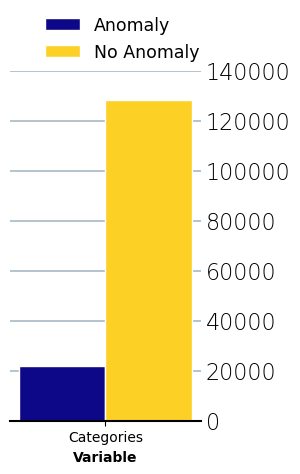

In [73]:
plot_target_col(df=train_df, target_col=TARGET_COL, max_y=140000, y_tick_interval=20000,
                target_class_names=class_names, pdf_filename="eda_categories")

In [74]:
# undersampling
rus = RandomUnderSampler(random_state=RND_SEED)
X_res, y_res = rus.fit_resample(X_train, y_train.astype(int))
X_res = X_res.reset_index(drop=True)
y_res = y_res.reset_index(drop=True)
train_df = pd.concat([X_res, y_res], axis=1)
train_df.head()

,timestamp,"Prepared statement cache hit rate : ((MXBean(com.bea:Name=source06,Type=JDBCDataSourceRuntime).PrepStmtCacheHitCount / MXBean(com.bea:Name=source06,Type=JDBCDataSourceRuntime).PrepStmtCacheMissCount))","Memory space usage : ((MXBean(java.lang:name=Code Cache,type=MemoryPool).Usage.committed / MXBean(java.lang:name=Code Cache,type=MemoryPool).Usage.max))","Available db connection activity : (d/dx (MXBean(com.bea:Name=source02,Type=JDBCDataSourceRuntime).NumAvailable))","Active connections : (MXBean(com.bea:Name=source03,Type=JDBCConnectionPoolRuntime).ActiveConnectionsCurrentCount)","DB connection started : (incld/dx (MXBean(com.bea:Name=source02,Type=JDBCDataSourceRuntime).ConnectionsTotalCount))",Heap usage activity : (d/dx (MXBean(java.lang:type=Memory).HeapMemoryUsage.used)),"Connection delay : (MXBean(com.bea:Name=source10,Type=JDBCDataSourceRuntime).ConnectionDelayTime)","Stuck threads : (MXBean(com.bea:Name=ThreadPoolRuntime,Type=ThreadPoolRuntime).StuckThreadCount)","DB connection started : (incld/dx (MXBean(com.bea:Name=source09,Type=JDBCConnectionPoolRuntime).ConnectionsTotalCount))",...,"Available db connection activity : (d/dx (MXBean(com.bea:Name=source02,Type=JDBCConnectionPoolRuntime).NumAvailable))","Memory space activity : (d/dx ((MXBean(java.lang:name=PS Eden Space,type=MemoryPool).Usage.committed / MXBean(java.lang:name=PS Eden Space,type=MemoryPool).Usage.max)))","Active transactions : (MXBean(com.bea:Name=JTARuntime,Type=JTARuntime).ActiveTransactionsTotalCount)",Process CPU : (\Process(java)\CPU),host_lphost06,host_lphost14,host_lphost15,process_wls1,process_wls2,isAnomaly
0,1443335520,1.0,0.406250,0.0,0.0,0.0,38851008.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,1,0,0,1,0,0
1,1439171640,1.0,0.970052,0.0,0.0,0.0,51522504.0,384.0,0.0,1.0,...,0.0,0.000000,0.0,0.0,0,0,1,0,1,0
2,1439964900,1.0,0.970052,0.0,0.0,0.0,247143320.0,384.0,0.0,0.0,...,0.0,0.006864,0.0,0.0,0,0,1,0,1,0
3,1426986720,1.0,0.825521,0.0,0.0,0.0,57498536.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0,0,1,1,0,0
4,1431246480,1.0,0.393229,0.0,0.0,0.0,52730824.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0,0,1,0,1,0


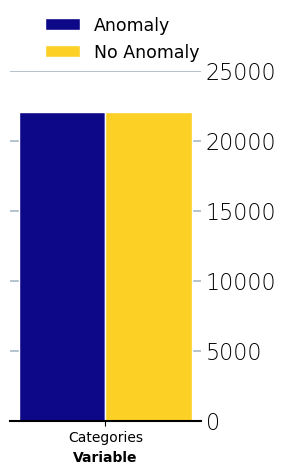

In [75]:
plot_target_col(df=train_df, target_col=TARGET_COL, max_y=25000, y_tick_interval=5000,
                target_class_names=class_names, pdf_filename="eda_categories_balanced")

In [76]:
# scaling training
scale_exclude_col_names = ["host_lphost06", "host_lphost14", "host_lphost15", "process_wls1",
                           "process_wls2", TARGET_COL, "timestamp"]
mms_train = MinMaxScaler()
train_df = scale_dataset(train_df, scale_exclude_col_names, scaler=mms_train)
mms_test = MinMaxScaler()
test_df = scale_dataset(test_df, scale_exclude_col_names, scaler=mms_test)

X_train, y_train = x_y_split(train_df, TARGET_COL)
X_test, y_test = x_y_split(test_df, TARGET_COL)

In [77]:
train_df.to_csv("data/train.csv", index=False)
test_df.to_csv("data/test.csv", index=False)

In [78]:
test_df[TARGET_COL].value_counts(normalize=True)

0    0.853299
1    0.146701
Name: isAnomaly, dtype: float64